# Capstone Project - The Battle of the Neighborhoods

## Introduction: Business Problem

Nowadays working at office or home office is one of the most frequent setups. In most cases such type of work requires seating for multiple hours a day, which brings very unhealthy static tension to the body.  
There are multiple types of sport activities to eliminate and compensiate such bad influence, one of very popular is yoga. Yoga implies combination of physical exercises with mental relaxing which also helps to decrease overall stress. Moreover most of yoga exersices do not require extreme physical pressure and are quite safe from injury prospective.  
All that said, yoga is quite nice choice for office workers who live in big urban areas.

Thus, building a recomendation system for finding best suitable yoga class for office workers based on certain criteria is valuable analytical problem that perfectly fits into _Clustering_ type of Data Science problems which could be solved by unsupervised learning algorithms.

# Libraries installation

In [ ]:
import sys
!{sys.executable} -m pip install pandas numpy folium requests sklearn matplotlib

Python libraries import:

In [173]:
import pandas as pd
import numpy as np
import folium
import requests
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Data

### Collection

Geo-data about Munich boroughs from [Wikipedia](https://en.wikipedia.org/wiki/Boroughs_of_Munich), [surface and population in each of them](http://www.total-munich.com/20160623888/blog/moving-to-munich/moving-to-munich-introduction-to-munich-s-boroughs.html) was manually constructed and stored into [munich_boroughs.csv](munich_boroughs.csv) CSV-file:

In [174]:
boroughs_df = pd.read_csv('munich_boroughs.csv')
boroughs_df.head()

,name,latitude,longitude,population,"surface, km2"
0,Altstadt-Lehel,48.136111,11.572222,20806,3.15
1,Ludwigsvorstadt-Isarvorstadt,48.127252,11.564758,52177,4.40
2,Maxvorstadt,48.150000,11.569444,52575,4.30
3,Schwabing-West,48.167222,11.586111,67094,4.36
4,Au-Haidhausen,48.131944,11.588889,60756,4.22


Foursquare API is used to obtain information about _Yoga Studios_ in each borough. Following API endpoints are specially useful to get needed info:
 - https://developer.foursquare.com/docs/api/venues/search
 - https://developer.foursquare.com/docs/api/venues/details

To narrow search results to Yoga classes Venues only we use _Yoga Studio_ `categoryId` = `4bf58dd8d48988d102941735` from [available API categories values](https://developer.foursquare.com/docs/resources/categories).  
Total number of venues in all boroughs after collection is truncated to no more than 100 rows. 

### Cleanup and feature extraction

Raw JSON data about _Venues_ retrieved from Foursquare API should be filtered to the following structure:
 - Foursquare ID
 - Name
 - Geo-location:
   - Latitude
   - Longitude
 - Contacts:
   - Phone
   - Website
   - Facebook
   - Twitter
   - Instagram
 - Openning hours
 - Rating
 
Mentioned structure is then populated with prices information manually to the best of researcher's effort. 
Populated data is then flattened and one-hot encoded to generate _feature-file_ for _K-Means Clustering_ algorithm to determine main types of offered Yoga classes in Munich (e.g. far from city center, but cheap; popular in the city center, etc.)

## Methodology

First, let's visualize boroughs centers on the map:

In [175]:
munich_latitude = 48.153333
munich_longitude = 11.566667
map_munich = folium.Map(location=[munich_latitude, munich_longitude], zoom_start=12)

for _, borough in boroughs_df.iterrows():
    label = folium.Popup(borough['name'], parse_html=True)
    folium.CircleMarker(
        [borough['latitude'], borough['longitude']],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich)

map_munich

Next we used Foursquare API to obtain information about Yoga Studios in each boroughs.  
Define Foursquare API calls parameters which have constant values:

In [ ]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20190929'
RADIUS=5000 # meters around location
LIMIT=100
# see https://developer.foursquare.com/docs/resources/categories for all possible values
YOGA_STUDIO_CATEGORY_ID='4bf58dd8d48988d102941735'

Retrieve information about Yoga Studios via Foursquare API call:

In [ ]:
venues = []
for _, borough in boroughs_df.iterrows():    

    url = 'https://api.foursquare.com/v2/venues/search?&client_id={client_id}&client_secret={client_secret}&v={v}&ll={lat},{lng}&radius={radius}&limit={limit}&categoryId={categoryId}'.format(
            client_id=CLIENT_ID, 
            client_secret=CLIENT_SECRET, 
            v=VERSION, 
            lat=borough['latitude'], 
            lng=borough['longitude'], 
            radius=RADIUS, 
            limit=LIMIT,
            categoryId=YOGA_STUDIO_CATEGORY_ID)
    response = requests.get(url).json()['response']['venues']

    if response:
        print("Found {number} venues for '{name}' borough.".format(number=len(response), name=borough['name']))
        for venue in response:
            address = venue['location']['address'] if 'address' in venue['location'] else ''
            venues.append([venue['id'], venue['name'], venue['location']['lat'], venue['location']['lng'], address])
    else:
        print("WARNING: No venues found for '{name}' borough.".format(name=borough['name']))
yoga_classes_raw_df = pd.DataFrame(venues, columns=['id', 'name', 'latitude', 'longitude', 'address'])

Let's get basic understanding of actual data:

In [ ]:
print('Raw df size:', yoga_classes_raw_df.shape)
yoga_classes_raw_df.head()

Remove duplicates:

In [ ]:
yoga_classes_df = yoga_classes_raw_df.drop_duplicates(subset='id').reset_index(drop=True)
print('Deduplicated df size:', yoga_classes_df.shape)

Utility function to convert latitute and longitude coordinates into distance, based on [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula):

In [ ]:
def haversine_formula(lat1, lon1, lat2, lon2):
    R = 6378.137; # radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180;
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180;
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a));
    d = R * c;
    
    return math.ceil(d * 1000) # meters

Calculate distance from Munich city center:

In [ ]:
munich_lat = 48.1451181
munich_lon = 11.5430782
yoga_classes_df['distance to center, m'] = yoga_classes_df.apply(lambda row: haversine_formula(row['latitude'], row['longitude'], munich_lat, munich_lon), axis=1)
yoga_classes_df.head()

To determine to which borough each yoga class belongs to:
1. Calculate distance between venue and borough center locations
1. Select borough with min distance

In [ ]:
borough_distances = []
for _, borough in boroughs_df.iterrows():
    column_name = borough['name']
    borough_distances.append(column_name)
    borough_lat = borough['latitude']
    borough_lon = borough['longitude']
    yoga_classes_df[column_name] = yoga_classes_df.apply(lambda row: haversine_formula(row['latitude'], row['longitude'], borough_lat, borough_lon), axis=1)
yoga_classes_df['borough'] = yoga_classes_df[borough_distances].T.idxmin()
yoga_classes_df.drop(columns=borough_distances, inplace=True)


Create dataframe with features for K-means algorihtm:

In [ ]:
yoga_classes_features_df = yoga_classes_df[['id', 'name', 'borough', 'distance to center, m']]
yoga_classes_features_df.head()

Get contacts, openning hours and rating information:

In [ ]:
ratings = []
phones = []
twitter = []
instagram = []
facebook = []
timeframes = []

for _, venue in yoga_classes_features_df.iterrows():

    url = 'https://api.foursquare.com/v2/venues/{venue_id}?&client_id={client_id}&client_secret={client_secret}&v={v}'.format(
        venue_id = venue['id'],
        client_id=CLIENT_ID, 
        client_secret=CLIENT_SECRET, 
        v=VERSION)
    response = requests.get(url).json()['response']['venue']
    
    ratings.append(response['rating'] if 'rating' in response else 'NA')
    if response['contact']:
        phones.append(response['contact']['phone'] if 'phone' in response['contact'] else 'NA')
        twitter.append(response['contact']['twitter'] if 'twitter' in response['contact'] else 'NA')
        instagram.append(response['contact']['instagram'] if 'instagram' in response['contact'] else 'NA')
        facebook.append(response['contact']['facebookName'] if 'facebookName' in response['contact'] else 'NA')
    else:
        phones.append('NA')
        twitter.append('NA')
        instagram.append('NA')
        facebook.append('NA')
    timeframes.append(response['hours']['timeframes'] if 'hours' in response else 'NA')
    print('Processed details about {venue_name}'.format(venue_name=venue['name']))
    
yoga_classes_features_df['rating'] = ratings
yoga_classes_features_df['phone'] = phones
yoga_classes_features_df['twitter'] = twitter
yoga_classes_features_df['instagram'] = instagram
yoga_classes_features_df['facebook'] = facebook
yoga_classes_features_df['timeframes'] = timeframes

Save to CSV-file to not make same call again:

In [ ]:
yoga_classes_features_df.to_csv('yoga_classes_features_df.csv', index=False)

Instead of rebuilding table with Yoga studios data from scratch, let's just load it from intermeidate CSV-file from local storage:

In [176]:
yoga_classes_df = pd.read_csv('yoga_classes_features_df.csv')
yoga_classes_df.head()

,id,name,borough,"distance to center, m",rating,phone,twitter,instagram,facebook,timeframes,morning_work,evening_work,weekend_work,free_trial_lesson,single_lesson_price,month_price,women_only
0,51d6f5bc498eae44762af325,yoga institut,Altstadt-Lehel,2215,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,18.0,90.0,0
1,533d7a0b498eec57aa03472b,Yogastudio Mami & Me,Schwabing-West,3041,NaN,4.915211e+12,NaN,NaN,NaN,NaN,1,1,1,0,10.0,85.0,1
2,55708236498e5d3055e6cfff,Patrick Broome Yoga,Altstadt-Lehel,2384,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,18.0,108.0,0
3,4ccc31d0ba0a548159753b59,Werkstatt 7,Ludwigsvorstadt-Isarvorstadt,2351,NaN,4.989517e+11,NaN,NaN,NaN,NaN,1,1,1,0,16.0,105.0,0
4,55eef8ba498e3c52398ad862,MahaShakti Yoga Studio,Maxvorstadt,2552,NaN,4.989273e+10,NaN,NaN,NaN,NaN,1,1,1,1,19.0,120.0,0


Most of records do not contain information about working time:

In [177]:
na_percentage = (yoga_classes_df['timeframes'].isna()).sum() / yoga_classes_df['name'].count() * 100
print(f" Percentage of NA timeframes: {na_percentage}%")

 Percentage of NA timeframes: 97.67441860465115%


and no information about prices.

Thus, this information is collected manually and added to table with Yoga studios data.

Working hours are collected manually and with _one-hot-encoding_ right away:
- if studio works at 08:00-10:00 AM, Mon-Fri, than `morning_work` column is `1`, otherwise `0`
- if studio works at 18:00-22:00 PM, Mon-Fri, than `evening_work` column is `1`, otherwise `0`
- if studio works on weekend Sat-Sun, than `weekend_work` column is `1`, otherwise `0`

Price information is divided into 3 columns:
- `trial_lesson` is `1` if free one-time trial lesson is available
- `single_lesson_price` - cost of one single lesson in EUR
- `month_price` - cost of month abonnement in EUR

Another important detail - I've only collected info from websites, so Yoga studios which do not have websites are excluded from resulting list of studios for analysis.

## Results

Prepare data for k-means clustering, retain only subset of all columns:

In [178]:
yoga_classes_df_clustering = yoga_classes_df.filter(['distance to center, m', 'morning_work', 'evening_work', 'weekend_work', 'month_price'])
yoga_classes_df_clustering.fillna(0.0, axis=1, inplace=True)

Normalize distance to city center column to avoid weight bias:

In [179]:
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(yoga_classes_df_clustering)
yoga_classes_df_clustering.loc[:,:] = scaled_values

Now, when data is prepared and cleaned, let's run k-means clustering:

In [180]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(yoga_classes_df_clustering)
yoga_classes_df_clustering.insert(0, 'cluster_label', kmeans.labels_)

In [181]:
yoga_classes_df_clustering.sort_values(by='cluster_label', inplace=True)
yoga_classes_df_clustering

,cluster_label,"distance to center, m",morning_work,evening_work,weekend_work,month_price
10,0,0.361660,0.0,0.0,0.0,0.888889
37,0,0.198805,0.0,0.0,0.0,0.888889
34,0,0.359841,0.0,0.0,0.0,1.000000
19,1,0.242810,1.0,0.0,1.0,0.666667
4,1,0.162335,1.0,0.0,1.0,0.666667
5,1,0.200710,1.0,0.0,1.0,0.638889
17,1,0.241337,1.0,0.0,1.0,0.716667
35,1,0.133229,1.0,0.0,1.0,0.972222
8,1,0.331341,1.0,0.0,1.0,0.666667
24,1,0.399861,1.0,0.0,1.0,0.716667


So, now let's add informative interpretation of analysed clusters:
* 0 - most expensive classes in the city center
* 1 - quite expensive classes close to the city center, work in mornings and on weekends
* 2 - average price classes that work over the weekend
* 3 - yoga classes in far-far away galaxy :)
* 4 - affordable classes in the city center only during work time
* 5 - classes without price information only during work time
* 6 - classes far from city center, but working in mornings and on weekends
* 7 - affordable classes in the city center working in mornings and on weekends
* 8 - classes without price information but working on weekends
* 9 - classes quite distanciated from center, but with average price

Adding clusters labels to original list of classes and retain only most important columns:

In [182]:
yoga_labeled = pd.merge(yoga_classes_df, yoga_classes_df_clustering['cluster_label'], left_index=True, right_index=True)
yoga_final = yoga_labeled[['name', 'borough','cluster_label']].sort_values(by=['borough'])
yoga_final.head()

,name,borough,cluster_label
0,yoga institut,Altstadt-Lehel,4
32,Yoga Garden,Altstadt-Lehel,4
2,Patrick Broome Yoga,Altstadt-Lehel,7
23,Prana Iyengar Yoga Institut,Altstadt-Lehel,4
5,Jivamukti Yoga,Altstadt-Lehel,1


Now, let's see percentage distribution of classes per borough:

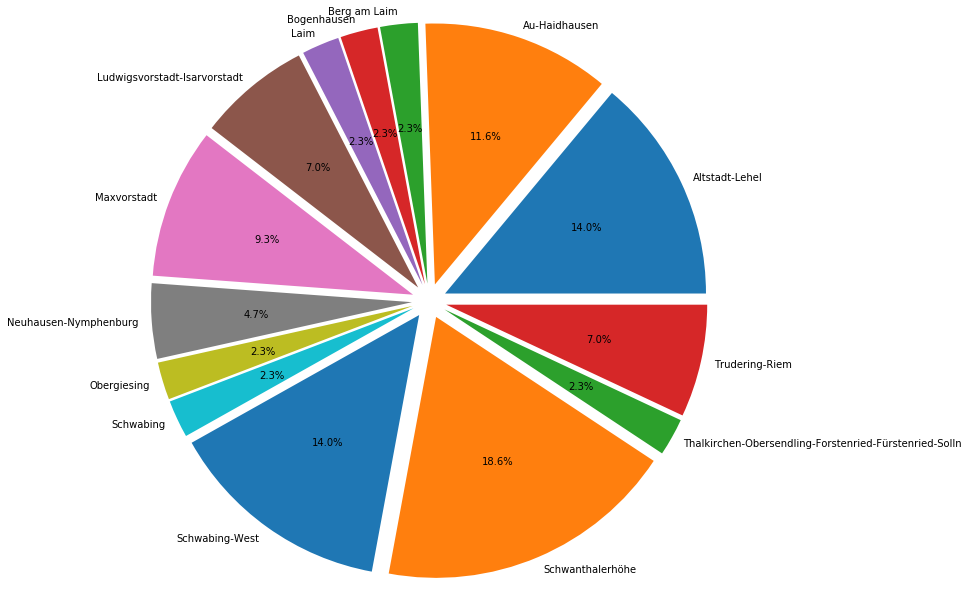

In [183]:
classes_per_borough = yoga_final[['borough', 'cluster_label']].groupby(['borough']).count()
classes_per_borough.reset_index(inplace=True)
values = classes_per_borough['cluster_label'].values
labels = classes_per_borough['borough'].values
explode = np.empty(len(values))
explode.fill(.2)
plt.pie(x = values,
    labels = labels,
    explode = explode,
    autopct='%1.1f%%',
    labeldistance = 1.05,
    radius = 3);

and some boroughs do not have any joga classes at all:

In [184]:
boroughs_classes = boroughs_df.merge(classes_per_borough, 
                                     left_on='name', 
                                     right_on='borough', 
                                     how='left')[['name', 'cluster_label']]
boroughs_without_classes = boroughs_classes[np.isnan(boroughs_classes['cluster_label'])][['name']]
boroughs_without_classes.sort_values(by=['name'], inplace=True)
boroughs_without_classes

,name
22,Allach-Untermenzing
21,Aubing-Lochhausen-Langwied
23,Feldmoching-Hasenbergl
19,Hadern
10,Milbertshofen-Am Hart
9,München-Moosach
20,Pasing-Obermenzing
15,Ramersdorf-Perlach
11,Schwabing-Freimann
5,Sendling


In [ ]:
#TBD

## Discussion

TBD

## Conclusion

TBD